In [301]:
import numpy as np
import gpflow
import trieste
from trieste.models.gpflow import build_gpr, GaussianProcessRegression
from trieste.space import Box
from trieste.data import Dataset
from functions import constraints
from functions import objectives
from functools import partial
import pickle
import matplotlib.pyplot as plt
import scipy
import tensorflow as tf

plt.style.use('plot_style.txt')

In [282]:
def forrester_function(x):
    return tf.square(6 * x - 2) * tf.math.sin(12 * x - 4) / 15

In [283]:
def create_model(search_space, num_rff_features, data):
    gpr = build_gpr(data, search_space, likelihood_variance=1e-6, mean=gpflow.mean_functions.Zero(), kernel_name="matern52")
    return GaussianProcessRegression(gpr, num_rff_features=num_rff_features, use_decoupled_sampler=True)

In [372]:
initial_data = (tf.constant([[-1e6]], dtype=tf.float64), tf.constant([[0]], dtype=tf.float64))
model = GaussianProcessRegression(gpflow.models.GPR(initial_data, noise_variance=1e-5, kernel=gpflow.kernels.SquaredExponential(variance=5, lengthscales=1), mean_function=gpflow.mean_functions.Zero()))

In [138]:
model

GaussianProcessRegression(<gpflow.models.gpr.GPR object at 0x15db6cd60>, Optimizer(optimizer=<gpflow.optimizers.scipy.Scipy object at 0x15dc8e190>, minimize_args={}, compile=True),10, 1000,True)

In [373]:
search_space = Box([0.0], [1.0])
observer = trieste.objectives.utils.mk_observer(forrester_function)
initial_inputs = search_space.sample(7, seed=42)
initial_inputs = tf.constant([[0.05], [0.21], [0.5], [0.62], [0.90]], dtype=tf.float64)
# initial_inputs = tf.cast(tf.linspace(0.0, 0.5, 10)[..., None], tf.float64)
# initial_inputs = tf.concat([initial_inputs, tf.constant([[1.0]], dtype=tf.float64)], 0)
# initial_inputs = tf.random.uniform(shape=[5], minval=0, maxval=1)
initial_data = observer(initial_inputs)
model.update(initial_data)
model.optimize(initial_data)

In [374]:
xs = tf.linspace(0, 1, 1000)[None,:, None]
ys = forrester_function(xs)

In [375]:
model_pred_mean, model_pred_var = model.predict(xs)
conf_interval = 1.96 * tf.sqrt(model_pred_var)

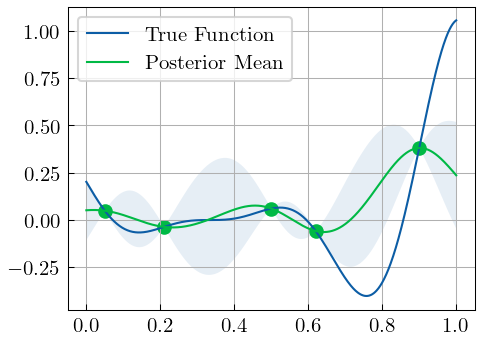

In [376]:
plt.plot(xs[0], ys[0], label="True Function")
plt.plot(xs[0], model_pred_mean[0], label="Posterior Mean")
plt.fill_between(tf.squeeze(xs), tf.squeeze(model_pred_mean) + tf.squeeze(conf_interval), tf.squeeze(model_pred_mean) - tf.squeeze(conf_interval), alpha=0.1)
plt.scatter(initial_data.query_points, initial_data.observations)
plt.legend()

In [304]:
initial_data

Dataset(query_points=<tf.Tensor: shape=(5, 1), dtype=float64, numpy=
array([[0.05],
       [0.21],
       [0.5 ],
       [0.6 ],
       [0.9 ]])>, observations=<tf.Tensor: shape=(5, 1), dtype=float64, numpy=
array([[ 0.04923425],
       [-0.03635629],
       [ 0.06061983],
       [-0.00996252],
       [ 0.38079669]])>)

In [313]:
def expected_improvement(f_star, mu, variance):
    # return the value of the acquisition function at each point in x
    # technically x doesn't need to be passed as an argument, but I kept
    # it as it was used in the PDF worksheet.
    standard_dev = np.sqrt(variance.flatten())
    f_star_vec = np.full(mu.shape[0], f_star)
    psi = scipy.stats.norm.cdf(f_star_vec, loc=mu.flatten(), scale=standard_dev)
    exploitation = np.multiply((f_star_vec - mu.flatten()), psi)
    pdf = scipy.stats.norm.pdf(f_star_vec, loc=mu.flatten(), scale=standard_dev)
    exploration = np.multiply(variance.flatten(), pdf)
    alpha = exploration + exploitation
    return alpha

In [356]:
def expected_improvement_tf(f_star, mu, variance):
    standard_dev = tf.sqrt(variance)
    f_star_vec = tf.cast(tf.repeat(f_star, mu.shape[0]), dtype=tf.float64)
    psi = scipy.stats.norm.cdf(f_star_vec, loc=mu, scale=standard_dev)
    exploitation = (f_star_vec - mu) * psi
    pdf = scipy.stats.norm.pdf(f_star_vec, loc=mu, scale=standard_dev)
    exploration = variance * pdf
    alpha = exploration + exploitation
    return alpha

In [357]:
ei = expected_improvement(-0.03635629, model_pred_mean.numpy(), model_pred_var.numpy())

In [358]:
ei2 = expected_improvement_tf(-0.03635629, tf.squeeze(model_pred_mean), tf.squeeze(model_pred_var))

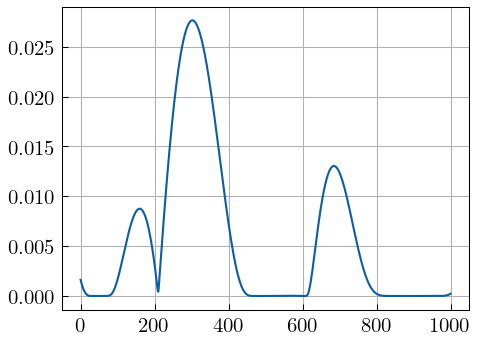

In [359]:
plt.plot(ei)

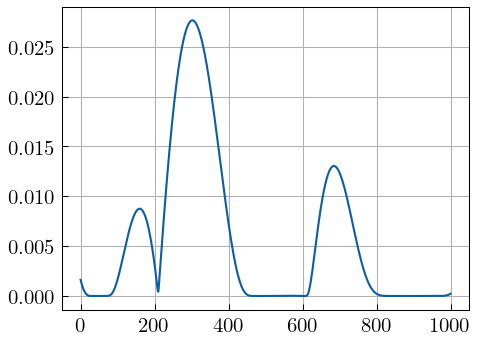

In [360]:
plt.plot(ei2)